In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from collections import defaultdict

from loader import load_to_dict, load_user_likes, save_likes

2025-11-30 21:45:15.601955: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-30 21:45:15.609303: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-30 21:45:15.641892: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-30 21:45:15.642821: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-30 21:45:16.544356: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
DATA_FILE = "review-Oregon_10.json.gz"
META_FILE = "meta-Oregon.json.gz"

In [4]:
review = load_to_dict(DATA_FILE)
meta = load_to_dict(META_FILE)

review_df = pd.DataFrame(review)
meta_df = pd.DataFrame(meta)

REVIEWS STATS: 
Total number of reviews: 6270332
Total unique users: 204623
Total unique items: 47121

Columns:  ['user_id', 'name', 'time', 'rating', 'text', 'pics', 'resp', 'gmap_id', 'text_length'] 

Rating distribution:
rating
1     251454
2     205157
3     633110
4    1479821
5    3700790
Name: count, dtype: int64 

User review count stats:
  Avg reviews per user:    30.643
  Median reviews per user: 19.0

Item review count stats:
  Avg reviews per item:    133.069
  Median reviews per item: 43.0

Number of interactions with rating ≥ 4: 5180611

Top 10 Most Popular gmap_id (by number of ratings):

                                       num_ratings  avg_rating
gmap_id                                                       
0x549575786b8b269f:0xb3548313bd7fccfd         7937    4.294444
0x54950c57cd36d3cb:0x6f866d66264752ab         7838    4.350344
0x5495a40b739922e1:0x1386e3022fac1181         7432    4.363159
0x5495a0b4338cb23b:0xdf44bd5a7cbcbde4         6712    3.893176
0x54ea92b04

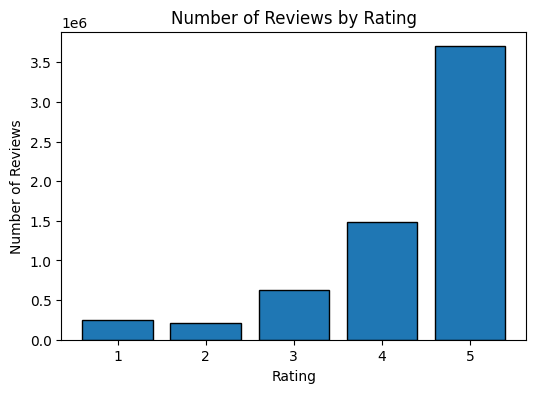

TEXT LENGTH STATS:

count    6.270332e+06
mean     6.914707e+01
std      1.473366e+02
min      0.000000e+00
25%      0.000000e+00
50%      1.900000e+01
75%      7.700000e+01
max      4.096000e+03
Name: text_length, dtype: float64


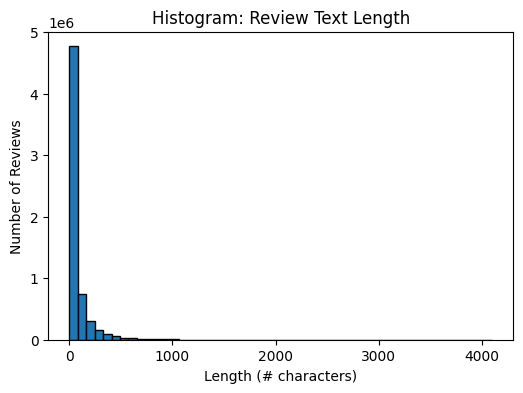

In [15]:
import matplotlib.pyplot as plt

print("REVIEWS STATS: ")

# Number of total reviews
num_reviews = len(review_df)

# Number of unique users
num_users = review_df["user_id"].nunique()

# Number of unique items (gmap_id)
num_items = review_df["gmap_id"].nunique()

# Rating distribution
rating_counts = review_df["rating"].value_counts().sort_index()

# Interactions per user stats
user_interaction_counts = review_df["user_id"].value_counts()
avg_reviews_per_user = user_interaction_counts.mean()
median_reviews_per_user = user_interaction_counts.median()

# Interactions per item stats
item_interaction_counts = review_df["gmap_id"].value_counts()
avg_reviews_per_item = item_interaction_counts.mean()
median_reviews_per_item = item_interaction_counts.median()

print(f"Total number of reviews: {num_reviews}")
print(f"Total unique users: {num_users}")
print(f"Total unique items: {num_items}\n")

print("Columns: ",list(review_df.columns),"\n")

print("Rating distribution:")
print(rating_counts, "\n")

print("User review count stats:")
print(f"  Avg reviews per user:    {avg_reviews_per_user:.3f}")
print(f"  Median reviews per user: {median_reviews_per_user}\n")

print("Item review count stats:")
print(f"  Avg reviews per item:    {avg_reviews_per_item:.3f}")
print(f"  Median reviews per item: {median_reviews_per_item}")

num_pos_interactions = (review_df["rating"] >= 4).sum()
print(f"\nNumber of interactions with rating ≥ 4: {num_pos_interactions}\n")

print("Top 10 Most Popular gmap_id (by number of ratings):\n")

item_stats = (
    review_df.groupby("gmap_id")
             .agg(
                 num_ratings=("rating", "count"),
                 avg_rating=("rating", "mean")
             )
             .sort_values("num_ratings", ascending=False)
             .head(10)
)

print(item_stats)
print()

rating_counts = review_df["rating"].value_counts().sort_index()

plt.figure(figsize=(6,4))
plt.bar(rating_counts.index.astype(str), rating_counts.values, edgecolor='black')

plt.title("Number of Reviews by Rating")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")

plt.show()

review_df["text_length"] = review_df["text"].fillna("").apply(len)

print("TEXT LENGTH STATS:\n")
print(review_df["text_length"].describe())

plt.figure(figsize=(6,4))
plt.hist(review_df["text_length"], bins=50, edgecolor="black")
plt.title("Histogram: Review Text Length")
plt.xlabel("Length (# characters)")
plt.ylabel("Number of Reviews")
plt.show()

In [22]:
print("METADATA STATS: ")
print("Columns in metadata:", list(meta_df.columns), "\n")

# Convert price symbols to numeric levels
price_levels = meta_df["price"].fillna("Unlisted").astype(str).apply(lambda x: 0 if x=="Unlisted" else len(x))
price_counts_by_length = price_levels.value_counts().sort_index()

# Map numeric levels to readable symbols
symbol_map = {0: "Unlisted", 1: "$", 2: "$$", 3: "$$$", 4: "$$$$"}
labels = [symbol_map.get(level, f"{level}-symbol") for level in price_counts_by_length.index]

# Escape $ symbols by prefixing with backslash
safe_labels = [label.replace("$", r"\$") for label in labels]

# Print counts
print("Price level counts (0 = Unlisted):")
for label, count in zip(labels, price_counts_by_length.values):
    print(f"{label}: {count}")

# ---- BAR CHART ----
plt.figure(figsize=(6,4))
plt.bar(safe_labels, price_counts_by_length.values, color='skyblue', edgecolor='black')
plt.title("Number of Businesses by Price Level")
plt.xlabel("Price Level")
plt.ylabel("Number of Businesses")
plt.show()

def parse_days_open(hours):
    days_open = [0]*7  # Monday=0 ... Sunday=6
    if isinstance(hours, list):
        for d in hours:
            day, time = d
            if str(time).lower() != "closed":
                if day == "Monday":
                    days_open[0] = 1
                elif day == "Tuesday":
                    days_open[1] = 1
                elif day == "Wednesday":
                    days_open[2] = 1
                elif day == "Thursday":
                    days_open[3] = 1
                elif day == "Friday":
                    days_open[4] = 1
                elif day == "Saturday":
                    days_open[5] = 1
                elif day == "Sunday":
                    days_open[6] = 1
    return sum(days_open)  # Total days open

# Apply to dataframe
meta_df["days_open"] = meta_df["hours"].apply(parse_days_open)

# Print stats
print("Days open per week (0 = unknown / all closed):")
print(meta_df["days_open"].value_counts().sort_index(), "\n")
print(meta_df["days_open"].describe())
print()

# Bar chart
days_counts = meta_df["days_open"].value_counts().sort_index()
plt.figure(figsize=(6,4))
plt.bar(days_counts.index, days_counts.values, color='lime', edgecolor='black')
plt.title("Number of Businesses by Days Open per Week")
plt.xlabel("Days Open per Week (0 = unknown / all closed)")
plt.ylabel("Number of Businesses")
plt.xticks(range(0,8))  # Show 0–7
plt.show()

meta_df["desc_length"] = meta_df["description"].fillna("").apply(len)
print(meta_df["desc_length"].describe(), "\n")

print("Examples:")
print(f"Shortest description length: {meta_df['desc_length'].min()}")
print(f"Longest description length:  {meta_df['desc_length'].max()}\n")


# Histogram of description lengths
plt.figure(figsize=(8,4))
plt.hist(meta_df["desc_length"], bins=40, color='lightcoral', edgecolor='black')
plt.title("Distribution of Description Lengths")
plt.xlabel("Description Length (number of characters)")
plt.ylabel("Number of Businesses")
plt.show()


METADATA STATS: 
Columns in metadata: ['name', 'address', 'gmap_id', 'description', 'latitude', 'longitude', 'category', 'avg_rating', 'num_of_reviews', 'price', 'hours', 'MISC', 'state', 'relative_results', 'url', 'days_listed', 'desc_length'] 

